**Install requirements**

In [95]:
!which virtualenv

/usr/local/bin/virtualenv


In [1]:
#pip install pyramid-arima

In [2]:
#!pip uninstall scikit-learn
!pip install scikit-learn

In [3]:
!pip install chart_studio

In [4]:
#pip install pmdarima

***Import Libraries***

In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras

import chart_studio.plotly as plot_mpl
import plotly.graph_objs as go
import xgboost as xgb
import keras.backend as K
import tensorflow as tf

from math import sqrt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima

from socket import socket
from statsmodels.tsa.seasonal import seasonal_decompose

#from keras.models import Sequential
#from tensorflow.keras.models import Sequential


from keras.layers import Conv1D, LSTM, TimeDistributed, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [6]:
#Set parameters to see all data
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [7]:
#from google.colab import files

In [8]:
#Upload train data set file from local to colabs area
#uploaded = files.upload()

In [9]:
# Load Train dataset
train = pd.read_csv("data/lite_data.csv")
train.head(5).append(train.tail(5))

,Price,Open,High,Low,Vol.,Change %
0,44.478,43.148,44.787,42.792,10.24M,3.08%
1,42.950,44.453,45.130,42.310,7.59M,-3.43%
2,44.947,42.978,45.182,42.582,14.85M,4.65%
3,46.025,44.947,46.556,43.962,8.88M,2.40%
4,46.047,46.002,46.540,45.179,18.32M,0.05%
117,76.375,73.751,76.961,71.414,8.21M,3.62%
118,73.376,76.225,77.061,68.289,9.78M,-3.93%
119,81.527,73.354,83.186,71.489,9.07M,11.11%
120,82.505,81.520,85.518,80.101,8.70M,1.20%
121,87.482,82.579,88.379,80.488,8.95M,6.03%


In [10]:
# Load test dataset
test = train[0:7].copy()
test.head(10)

,Price,Open,High,Low,Vol.,Change %
0,44.478,43.148,44.787,42.792,10.24M,3.08%
1,42.950,44.453,45.130,42.310,7.59M,-3.43%
2,44.947,42.978,45.182,42.582,14.85M,4.65%
3,46.025,44.947,46.556,43.962,8.88M,2.40%
4,46.047,46.002,46.540,45.179,18.32M,0.05%
5,46.078,46.019,46.538,44.582,19.53M,0.07%
6,45.246,46.042,47.120,44.851,10.51M,-1.81%


In [11]:
cols = test.columns
for i in range(test.shape[0]):
    for col in cols:
        test[col] = 0

In [12]:
test.head(10)

,Price,Open,High,Low,Vol.,Change %
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,0,0,0,0,0,0


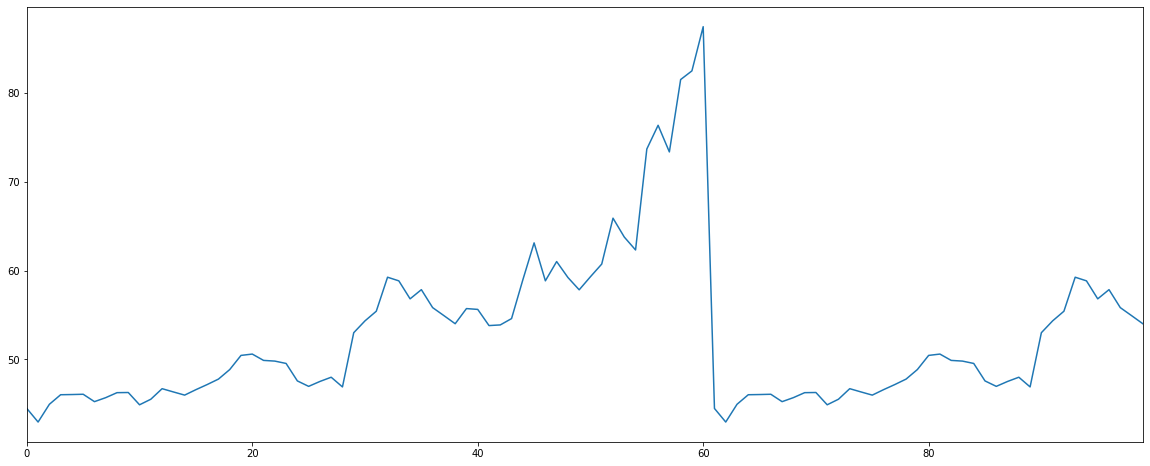

In [13]:
#Plot data
train[:100].Price.plot(figsize=(20,8))

In [14]:
train.shape

(122, 6)

In [15]:
train.dtypes

Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %     object
dtype: object

# **Preprocess**

In [16]:
#train = train.set_index(['Date'])

In [17]:
#train.index = pd.to_datetime(train.index)

In [18]:
train.dtypes

Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %     object
dtype: object

In [19]:
#Stationary Control
#if P-Value is smaller than 0.005, we can say that there is stationary, else there is no stationary
#if our data has no stationary, I will plan to use differences

class Stationary:
    def __init__(self, significance=.005):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None

    def ADF_Stationarity_Test(self, timeseries, printResults=True):

        # Dickey-Fuller test:
        print(timeseries)
        try:
            adfTest = adfuller(timeseries, autolag='AIC')

            self.pValue = adfTest[1]

            if (self.pValue < self.SignificanceLevel):
                self.isStationary = True
            else:
                self.isStationary = False
            #self.isStationary=True
            if printResults:
                dfResults = pd.Series(adfTest[0:4],
                                      index=['ADF Test Statistic', 'P-Value', '# Lags Used', '# Observations Used'])

                # Add Critical Values
                for key, value in adfTest[4].items():
                    dfResults['Critical Value (%s)' % key] = value

                print('Augmented Dickey-Fuller Test Results:')
                print(dfResults)
        except Exception as e:
          print(e)
          self.isStationary = False

In [20]:
sTest = Stationary()

In [21]:
sTest.ADF_Stationarity_Test(train['Price'])
print(sTest.isStationary)

0      44.478
1      42.950
2      44.947
3      46.025
4      46.047
5      46.078
6      45.246
7      45.697
8      46.258
9      46.276
10     44.892
11     45.518
12     46.707
13     46.340
14     45.982
15     46.596
16     47.172
17     47.787
18     48.861
19     50.455
20     50.605
21     49.892
22     49.814
23     49.549
24     47.581
25     46.968
26     47.520
27     47.997
28     46.905
29     53.012
30     54.346
31     55.431
32     59.263
33     58.852
34     56.826
35     57.861
36     55.838
37     54.937
38     54.023
39     55.730
40     55.636
41     53.815
42     53.888
43     54.603
44     58.961
45     63.130
46     58.856
47     61.027
48     59.232
49     57.843
50     59.320
51     60.744
52     65.913
53     63.787
54     62.332
55     73.705
56     76.375
57     73.376
58     81.527
59     82.505
60     87.482
61     44.478
62     42.950
63     44.947
64     46.025
65     46.047
66     46.078
67     45.246
68     45.697
69     46.258
70     46.276
71    

## **P-Values is higher than 0.005, so there no stationary.**

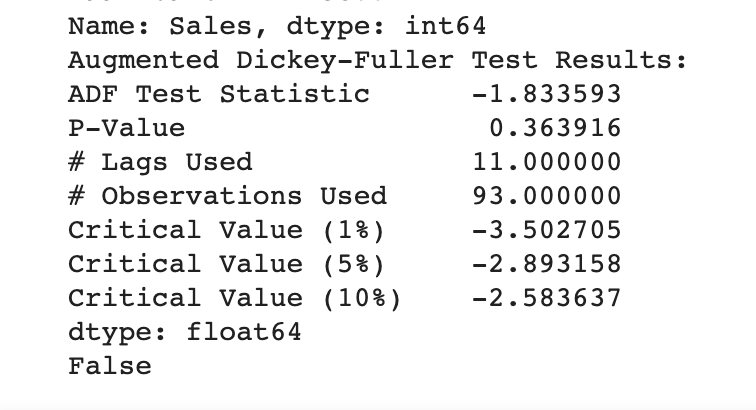

In [22]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        # print(interval, dataset[i], dataset[i - interval])
        diff.append(value)
    return pd.Series(diff)

In [23]:
diff_values = difference(train['Price'], 1)

In [24]:
 # split train test datasets
 xtrain, xtest = diff_values[0:-8], diff_values[-8:]

In [25]:
xtest

113    -2.126
114    -1.455
115    11.373
116     2.670
117    -2.999
118     8.151
119     0.978
120     4.977
dtype: float64

In [26]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    dfx = pd.DataFrame(data)
    df = dfx.assign(**{
        '{} (t-{})'.format(col, t): dfx[col].shift(t)
        for t in range(lag+1)
        for col in dfx
    })

    df=df.drop([df.columns[0]], axis=1)
    df=df[df.columns[::-1]]
    return df[lag:]

In [27]:
# scale train and test data to [-1, 1] with MinMaxScaler
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler()  
    
    # StandardScaler()
    scaler = scaler.fit(train)

    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    tr_scaled = scaler.transform(train)

    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    ts_scaled = scaler.transform(test)
    
    return scaler, tr_scaled, ts_scaled

In [28]:
# reorganize dataset acording to window size
values_unscaled = np.concatenate((xtrain, xtest))
supervised_raw = timeseries_to_supervised(values_unscaled, 30)

In [29]:
supervised_raw

,0 (t-30),0 (t-29),0 (t-28),0 (t-27),0 (t-26),0 (t-25),0 (t-24),0 (t-23),0 (t-22),0 (t-21),0 (t-20),0 (t-19),0 (t-18),0 (t-17),0 (t-16),0 (t-15),0 (t-14),0 (t-13),0 (t-12),0 (t-11),0 (t-10),0 (t-9),0 (t-8),0 (t-7),0 (t-6),0 (t-5),0 (t-4),0 (t-3),0 (t-2),0 (t-1),0 (t-0)
30,-1.528,1.997,1.078,0.022,0.031,-0.832,0.451,0.561,0.018,-1.384,0.626,1.189,-0.367,-0.358,0.614,0.576,0.615,1.074,1.594,0.150,-0.713,-0.078,-0.265,-1.968,-0.613,0.552,0.477,-1.092,6.107,1.334,1.085
31,1.997,1.078,0.022,0.031,-0.832,0.451,0.561,0.018,-1.384,0.626,1.189,-0.367,-0.358,0.614,0.576,0.615,1.074,1.594,0.150,-0.713,-0.078,-0.265,-1.968,-0.613,0.552,0.477,-1.092,6.107,1.334,1.085,3.832
32,1.078,0.022,0.031,-0.832,0.451,0.561,0.018,-1.384,0.626,1.189,-0.367,-0.358,0.614,0.576,0.615,1.074,1.594,0.150,-0.713,-0.078,-0.265,-1.968,-0.613,0.552,0.477,-1.092,6.107,1.334,1.085,3.832,-0.411
33,0.022,0.031,-0.832,0.451,0.561,0.018,-1.384,0.626,1.189,-0.367,-0.358,0.614,0.576,0.615,1.074,1.594,0.150,-0.713,-0.078,-0.265,-1.968,-0.613,0.552,0.477,-1.092,6.107,1.334,1.085,3.832,-0.411,-2.026
34,0.031,-0.832,0.451,0.561,0.018,-1.384,0.626,1.189,-0.367,-0.358,0.614,0.576,0.615,1.074,1.594,0.150,-0.713,-0.078,-0.265,-1.968,-0.613,0.552,0.477,-1.092,6.107,1.334,1.085,3.832,-0.411,-2.026,1.035
35,-0.832,0.451,0.561,0.018,-1.384,0.626,1.189,-0.367,-0.358,0.614,0.576,0.615,1.074,1.594,0.150,-0.713,-0.078,-0.265,-1.968,-0.613,0.552,0.477,-1.092,6.107,1.334,1.085,3.832,-0.411,-2.026,1.035,-2.023
36,0.451,0.561,0.018,-1.384,0.626,1.189,-0.367,-0.358,0.614,0.576,0.615,1.074,1.594,0.150,-0.713,-0.078,-0.265,-1.968,-0.613,0.552,0.477,-1.092,6.107,1.334,1.085,3.832,-0.411,-2.026,1.035,-2.023,-0.901
37,0.561,0.018,-1.384,0.626,1.189,-0.367,-0.358,0.614,0.576,0.615,1.074,1.594,0.150,-0.713,-0.078,-0.265,-1.968,-0.613,0.552,0.477,-1.092,6.107,1.334,1.085,3.832,-0.411,-2.026,1.035,-2.023,-0.901,-0.914
38,0.018,-1.384,0.626,1.189,-0.367,-0.358,0.614,0.576,0.615,1.074,1.594,0.150,-0.713,-0.078,-0.265,-1.968,-0.613,0.552,0.477,-1.092,6.107,1.334,1.085,3.832,-0.411,-2.026,1.035,-2.023,-0.901,-0.914,1.707
39,-1.384,0.626,1.189,-0.367,-0.358,0.614,0.576,0.615,1.074,1.594,0.150,-0.713,-0.078,-0.265,-1.968,-0.613,0.552,0.477,-1.092,6.107,1.334,1.085,3.832,-0.411,-2.026,1.035,-2.023,-0.901,-0.914,1.707,-0.094


In [30]:
supervised_raw = supervised_raw.values.astype("float32")

In [31]:
supervised_raw

array([[-1.528,  1.997,  1.078, ...,  6.107,  1.334,  1.085],
       [ 1.997,  1.078,  0.022, ...,  1.334,  1.085,  3.832],
       [ 1.078,  0.022,  0.031, ...,  1.085,  3.832, -0.411],
       ...,
       [-1.092,  6.107,  1.334, ...,  2.67 , -2.999,  8.151],
       [ 6.107,  1.334,  1.085, ..., -2.999,  8.151,  0.978],
       [ 1.334,  1.085,  3.832, ...,  8.151,  0.978,  4.977]],
      dtype=float32)

In [32]:
scaler, train_scaled, test_scaled = scale(xtrain.values.reshape(len(xtrain), 1), xtest.values.reshape(len(xtest), 1))

In [33]:
values_scaled = np.concatenate((train_scaled, test_scaled))

In [34]:
supervised = timeseries_to_supervised(values_scaled, 30)

supervised_values = supervised.values.astype('float32')

##split supervised data into train and test-sets
supervised_train, supervised_test = supervised_raw[0:-8], supervised_raw[-8:]
train_scaled, test_scaled = supervised_values[0:-8], supervised_values[-8:]

In [35]:
train_scaled

array([[0.76274896, 0.82757413, 0.81067365, ..., 0.9031576 , 0.8153815 ,
        0.81080234],
       [0.82757413, 0.81067365, 0.7912536 , ..., 0.8153815 , 0.81080234,
        0.86132   ],
       [0.81067365, 0.7912536 , 0.79141915, ..., 0.81080234, 0.86132   ,
        0.78329074],
       ...,
       [0.7936076 , 0.7777369 , 0.78941464, ..., 0.7578388 , 0.76530516,
        0.8180113 ],
       [0.7777369 , 0.78941464, 0.7859757 , ..., 0.76530516, 0.8180113 ,
        0.8170366 ],
       [0.78941464, 0.7859757 , 0.7546573 , ..., 0.8180113 , 0.8170366 ,
        0.88590765]], dtype=float32)

In [36]:
train_X, train_y = train_scaled[:, :-1], train_scaled[:, -1]
test_X, test_y = test_scaled[:, :-1], test_scaled[:, -1]

In [37]:
train_y.reshape(train_y.shape[0], 1)

array([[0.81080234],
       [0.86132   ],
       [0.78329074],
       [0.75359064],
       [0.8098829 ],
       [0.75364584],
       [0.7742796 ],
       [0.7740405 ],
       [0.822241  ],
       [0.7891204 ],
       [0.75736064],
       [0.79219157],
       [0.803998  ],
       [0.87099326],
       [0.86751753],
       [0.71224964],
       [0.83077407],
       [0.7578388 ],
       [0.76530516],
       [0.8180113 ],
       [0.8170366 ],
       [0.88590765],
       [0.75175166],
       [0.76409143],
       [1.        ],
       [0.83995074],
       [0.7356971 ],
       [0.940747  ],
       [0.8088346 ],
       [0.88237673],
       [0.        ],
       [0.76274896],
       [0.82757413],
       [0.81067365],
       [0.7912536 ],
       [0.79141915],
       [0.77554846],
       [0.799143  ],
       [0.80116594],
       [0.7911801 ],
       [0.76539713],
       [0.8023613 ],
       [0.81271493],
       [0.7840999 ],
       [0.7842654 ],
       [0.8021406 ],
       [0.8014418 ],
       [0.802

In [38]:
# prepare train dataset for lstm
train_X_lstm = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X_lstm = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [39]:
# prepare test dataset for lstm
train_Y_lstm = train_y.reshape((train_y.shape[0], 1, 1))
test_Y_lstm = test_y.reshape((test_y.shape[0], 1, 1))

In [40]:
test_scaled[:, -1]

array([0.75175166, 0.76409143, 1.        , 0.83995074, 0.7356971 ,
       0.940747  , 0.8088346 , 0.88237673], dtype=float32)

In [41]:
train_y

array([0.81080234, 0.86132   , 0.78329074, 0.75359064, 0.8098829 ,
       0.75364584, 0.7742796 , 0.7740405 , 0.822241  , 0.7891204 ,
       0.75736064, 0.79219157, 0.803998  , 0.87099326, 0.86751753,
       0.71224964, 0.83077407, 0.7578388 , 0.76530516, 0.8180113 ,
       0.8170366 , 0.88590765, 0.75175166, 0.76409143, 1.        ,
       0.83995074, 0.7356971 , 0.940747  , 0.8088346 , 0.88237673,
       0.        , 0.76274896, 0.82757413, 0.81067365, 0.7912536 ,
       0.79141915, 0.77554846, 0.799143  , 0.80116594, 0.7911801 ,
       0.76539713, 0.8023613 , 0.81271493, 0.7840999 , 0.7842654 ,
       0.8021406 , 0.8014418 , 0.802159  , 0.81060004, 0.82016295,
       0.7936076 , 0.7777369 , 0.78941464, 0.7859757 , 0.7546573 ,
       0.77957594, 0.8010004 , 0.79962116, 0.77076703, 0.9031576 ,
       0.8153815 , 0.81080234, 0.86132   , 0.78329074, 0.75359064,
       0.8098829 , 0.75364584, 0.7742796 , 0.7740405 , 0.822241  ,
       0.7891204 , 0.75736064, 0.79219157, 0.803998  , 0.87099

In [42]:
train_y.shape

(83,)

# **XGBRegressor**

In [43]:
# XGBRegressor Training
now = datetime.now()
print("Process started at : ",now)

parameters = { 'gamma' : [0, 0.1, 0.3, 1], 'learning_rate' : [0.001, 0.01, 0.1], 
              'max_depth' : [2, 4, 6, 7, 12], 
              'n_estimators' : [10, 45, 90, 100, 150, 250],
              'nthread' : [-1], 'reg_alpha' : [1], 'reg_lambda' : [1], 'seed' : [10] }

bst = xgb.XGBRegressor()
xgb_grid = GridSearchCV(bst,
                        parameters,
                        cv=5,
                        n_jobs=-1,
                        verbose=True,
                        )
xgb_grid.fit(train_X, train_y, eval_set=[(train_X, train_y)], early_stopping_rounds=50)

end = datetime.now()
print("Process finished at : ", end)
print("Process took : ", end-now)

Process started at :  2020-11-22 01:21:27.091317
Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 516 tasks      | elapsed:    4.1s


[0]	validation_0-rmse:0.28352
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.26019
[2]	validation_0-rmse:0.23947
[3]	validation_0-rmse:0.22111
[4]	validation_0-rmse:0.20489
[5]	validation_0-rmse:0.19060
[6]	validation_0-rmse:0.17805
[7]	validation_0-rmse:0.16707
[8]	validation_0-rmse:0.15750
[9]	validation_0-rmse:0.14919
[10]	validation_0-rmse:0.14200
[11]	validation_0-rmse:0.13580
[12]	validation_0-rmse:0.13048
[13]	validation_0-rmse:0.12593
[14]	validation_0-rmse:0.12204
[15]	validation_0-rmse:0.11873
[16]	validation_0-rmse:0.11592
[17]	validation_0-rmse:0.11354
[18]	validation_0-rmse:0.11152
[19]	validation_0-rmse:0.10981
[20]	validation_0-rmse:0.10837
[21]	validation_0-rmse:0.10715
[22]	validation_0-rmse:0.10611
[23]	validation_0-rmse:0.10523
[24]	validation_0-rmse:0.10449
[25]	validation_0-rmse:0.10386
[26]	validation_0-rmse:0.10332
[27]	validation_0-rmse:0.10286
[28]	validation_0-rmse:0.10247
[29]	validation_0-rmse:0.10214
[30]	validation

[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:    9.6s finished


In [44]:
xgb_grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             random_state=10, reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
             seed=10, subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [45]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))

    inverted = scaler.inverse_transform(array)
    ##print("converting %s to %s" % (value,inverted[0, -1]))
    return inverted[0, -1]

In [46]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history.iloc[-interval]

In [47]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / y_true)) * 100

In [48]:
test_scaled

array([[0.7859757 , 0.7546573 , 0.77957594, 0.8010004 , 0.79962116,
        0.77076703, 0.9031576 , 0.8153815 , 0.81080234, 0.86132   ,
        0.78329074, 0.75359064, 0.8098829 , 0.75364584, 0.7742796 ,
        0.7740405 , 0.822241  , 0.7891204 , 0.75736064, 0.79219157,
        0.803998  , 0.87099326, 0.86751753, 0.71224964, 0.83077407,
        0.7578388 , 0.76530516, 0.8180113 , 0.8170366 , 0.88590765,
        0.75175166],
       [0.7546573 , 0.77957594, 0.8010004 , 0.79962116, 0.77076703,
        0.9031576 , 0.8153815 , 0.81080234, 0.86132   , 0.78329074,
        0.75359064, 0.8098829 , 0.75364584, 0.7742796 , 0.7740405 ,
        0.822241  , 0.7891204 , 0.75736064, 0.79219157, 0.803998  ,
        0.87099326, 0.86751753, 0.71224964, 0.83077407, 0.7578388 ,
        0.76530516, 0.8180113 , 0.8170366 , 0.88590765, 0.75175166,
        0.76409143],
       [0.77957594, 0.8010004 , 0.79962116, 0.77076703, 0.9031576 ,
        0.8153815 , 0.81080234, 0.86132   , 0.78329074, 0.75359064,
      

In [49]:
len(test_scaled)

8

In [50]:
train['Price'].iloc[-9]

65.913

In [51]:
#Invert scale predictions to time series
predictions = list()
start = 8 # test period
l = len(test_scaled) - start

rmse = []
mape = []

for i in range(len(test_scaled)):
    X1, y = test_scaled[l, 0:-1], test_scaled[l, -1]
    X1 = X1[-30:] # ts_window

    # prediction 
    # pred = predict()
    X1 = X1.reshape((1,-1))
    pred = xgb_grid.predict(X1)

    yhat = invert_scale(scaler, X1[0], pred)
        
    l=l+1
    
    yhat = inverse_difference(train['Price'], yhat, len(test_scaled) + 1 - i) # if not stationary 

    predictions.append(yhat)
    

    rmse.append(sqrt(mean_squared_error([train['Price'][-8:].iloc[i]], [yhat])))
    mape.append(mean_absolute_percentage_error([train['Price'][-8:].iloc[i]], [yhat]))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths 

In [52]:
print("Test RMSE:", np.mean(rmse))
print("Test MAPE:", np.mean(mape))

Test RMSE: 4.470076034098865
Test MAPE: 5.804595129853684


In [53]:
predictions

[65.39719586360454,
 63.27119586360454,
 61.81619586360454,
 73.18919586360454,
 75.85919586360454,
 72.86019586360455,
 81.01119586360454,
 81.98919586360454]

In [54]:
result_df = pd.read_csv("data/lite_data.csv")

In [55]:
result_df = result_df[-8:]

In [56]:
result_df.head(9)

,Price,Open,High,Low,Vol.,Change %
114,63.787,65.923,66.326,61.690,7.82M,-3.23%
115,62.332,63.799,64.447,61.045,9.45M,-2.28%
116,73.705,62.308,74.613,62.084,10.44M,18.25%
117,76.375,73.751,76.961,71.414,8.21M,3.62%
118,73.376,76.225,77.061,68.289,9.78M,-3.93%
119,81.527,73.354,83.186,71.489,9.07M,11.11%
120,82.505,81.520,85.518,80.101,8.70M,1.20%
121,87.482,82.579,88.379,80.488,8.95M,6.03%


In [57]:
result_df['XGB_Predictions'] = 0
for i in range(7):
    result_df['XGB_Predictions'].iloc[i] = predictions[i+1]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



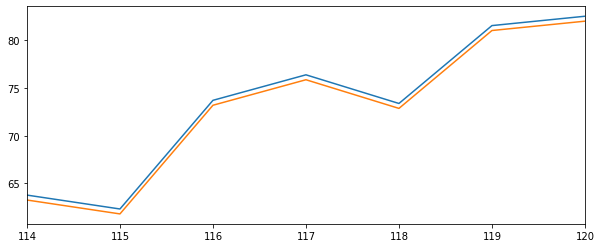

In [58]:
result_df[:7].Price.plot(figsize=(10,4))
result_df[:7].XGB_Predictions.plot(figsize=(10,4))

In [59]:
result_df.head(15)

,Price,Open,High,Low,Vol.,Change %,XGB_Predictions
114,63.787,65.923,66.326,61.690,7.82M,-3.23%,63.271196
115,62.332,63.799,64.447,61.045,9.45M,-2.28%,61.816196
116,73.705,62.308,74.613,62.084,10.44M,18.25%,73.189196
117,76.375,73.751,76.961,71.414,8.21M,3.62%,75.859196
118,73.376,76.225,77.061,68.289,9.78M,-3.93%,72.860196
119,81.527,73.354,83.186,71.489,9.07M,11.11%,81.011196
120,82.505,81.520,85.518,80.101,8.70M,1.20%,81.989196
121,87.482,82.579,88.379,80.488,8.95M,6.03%,0.000000


In [60]:
train.head(5).append(train.tail(5))

,Price,Open,High,Low,Vol.,Change %
0,44.478,43.148,44.787,42.792,10.24M,3.08%
1,42.950,44.453,45.130,42.310,7.59M,-3.43%
2,44.947,42.978,45.182,42.582,14.85M,4.65%
3,46.025,44.947,46.556,43.962,8.88M,2.40%
4,46.047,46.002,46.540,45.179,18.32M,0.05%
117,76.375,73.751,76.961,71.414,8.21M,3.62%
118,73.376,76.225,77.061,68.289,9.78M,-3.93%
119,81.527,73.354,83.186,71.489,9.07M,11.11%
120,82.505,81.520,85.518,80.101,8.70M,1.20%
121,87.482,82.579,88.379,80.488,8.95M,6.03%


# **AutoArima**

In [61]:
train[:-8].head(10)

,Price,Open,High,Low,Vol.,Change %
0,44.478,43.148,44.787,42.792,10.24M,3.08%
1,42.950,44.453,45.130,42.310,7.59M,-3.43%
2,44.947,42.978,45.182,42.582,14.85M,4.65%
3,46.025,44.947,46.556,43.962,8.88M,2.40%
4,46.047,46.002,46.540,45.179,18.32M,0.05%
5,46.078,46.019,46.538,44.582,19.53M,0.07%
6,45.246,46.042,47.120,44.851,10.51M,-1.81%
7,45.697,45.195,45.857,44.953,11.04M,1.00%
8,46.258,45.697,46.714,45.423,10.93M,1.23%
9,46.276,46.266,48.477,45.324,14.41M,0.04%


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

the 'freq' keyword is deprecated, use 'period' instead



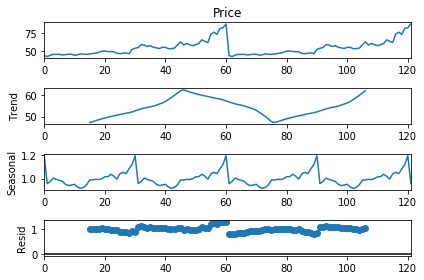

In [62]:
result = seasonal_decompose(train.Price, freq=30, model='multiplicative')
fig = result.plot()

In [63]:
arima_train = train[:-8].Price
arima_test = train[-8:].Price

(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [64]:
# Arima Training
now = datetime.now()
print("Arima process started at : ",now)

arima_stepwise_model = auto_arima(arima_train, start_p=0, start_q=0,
                           max_p=13, max_q=13, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,
                           n_jobs=10)#n_jobs for parallel process
end = datetime.now()
print("Arima process finished at : ", end)
print("Process took : ", end-now)

print(arima_stepwise_model)

Arima process started at :  2020-11-22 01:21:54.413067
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=677.908, Time=0.01 sec


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pmdarima/arima/_validation.py:75: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



 ARIMA(1,1,0)(1,1,0)[12]             : AIC=652.262, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=678.875, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=643.805, Time=0.17 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=643.046, Time=0.11 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=651.619, Time=0.03 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=643.507, Time=0.17 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=643.936, Time=0.43 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=645.003, Time=0.27 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]          
Total fit time: 4.126 seconds
Arima process finished at :  2020-11-22 01:21:58.551446
Process took :  0:00:04.1383

In [65]:
# Fit arima model
arima_predicts = arima_stepwise_model.fit(arima_train)

In [66]:
# Predict results with auto-arima
future_forecast = arima_predicts.predict(n_periods=8)

In [67]:
future_forecast

array([67.55606896, 68.35924462, 69.45943346, 72.40579777, 73.55876288,
       71.29077165, 72.35588297, 70.43119423])

In [68]:
arima_rmse = sqrt(mean_squared_error(train['Price'][-8:], future_forecast))
arima_mape = mean_absolute_percentage_error(train['Price'][-8:], future_forecast)

In [69]:
print("Test RMSE:", np.mean(arima_rmse))
print("Test MAPE:", np.mean(arima_mape))

Test RMSE: 8.535669912765528
Test MAPE: 8.89152395014571


In [70]:
result_df.shape

(8, 7)

In [71]:
result_df['Arima_Predictions'] = future_forecast
result_df.head(8)

,Price,Open,High,Low,Vol.,Change %,XGB_Predictions,Arima_Predictions
114,63.787,65.923,66.326,61.690,7.82M,-3.23%,63.271196,67.556069
115,62.332,63.799,64.447,61.045,9.45M,-2.28%,61.816196,68.359245
116,73.705,62.308,74.613,62.084,10.44M,18.25%,73.189196,69.459433
117,76.375,73.751,76.961,71.414,8.21M,3.62%,75.859196,72.405798
118,73.376,76.225,77.061,68.289,9.78M,-3.93%,72.860196,73.558763
119,81.527,73.354,83.186,71.489,9.07M,11.11%,81.011196,71.290772
120,82.505,81.520,85.518,80.101,8.70M,1.20%,81.989196,72.355883
121,87.482,82.579,88.379,80.488,8.95M,6.03%,0.000000,70.431194


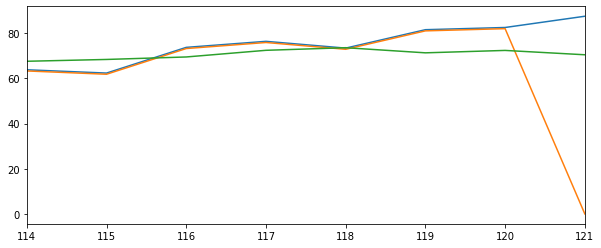

In [72]:
result_df[:8].Price.plot(figsize=(10,4))
result_df[:8].XGB_Predictions.plot(figsize=(10,4))
result_df[:8].Arima_Predictions.plot(figsize=(10,4))

In [73]:
#result_df.head(5).append(result_df.tail(5))
result_df.shape

(8, 8)

# **Long Short - Term Memory (LSTM)**

In [74]:
# define parameters
verbose, epochs, batch_size = 1, 50, 10
n_timesteps, n_features, n_outputs = train_X_lstm.shape[1], train_X_lstm.shape[2], train_Y_lstm.shape[1]

In [75]:
n_timesteps, n_features, n_outputs

(1, 30, 1)

In [76]:
pip list | grep tensorflow

tensorflow               1.13.1
tensorflow-estimator     1.13.0
Note: you may need to restart the kernel to use updated packages.


In [77]:
!pip uninstall tensorflow -y
!pip install tensorflow==1.13.1

Found existing installation: tensorflow 1.13.1
Uninstalling tensorflow-1.13.1:
  Successfully uninstalled tensorflow-1.13.1
  Using cached tensorflow-1.13.1-cp36-cp36m-macosx_10_11_x86_64.whl (71.6 MB)


In [89]:
# define model
lstm_model = keras.Sequential()
"""lstm_model.add(Conv1D(filters=32, kernel_size=5,
                  strides=1, padding="causal",
                  activation="relu", input_shape=(n_timesteps, n_features)))"""
lstm_model.add(keras.layers.LSTM(
  units=128,
  input_shape=(train_X_lstm.shape[1], train_Y_lstm.shape[2])
))
#add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))

In [90]:
lstm_model.add(keras.layers.Dense(units=1))
lstm_model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

In [91]:
"""lstm_model.add(LSTM(200, activation='relu', return_sequences=True))
# lstm_model.add(RepeatVector(n_outputs))
lstm_model.add(LSTM(200, activation='relu', return_sequences=True))
lstm_model.add(TimeDistributed(Dense(1, activation='relu')))
#lstm_model.add(TimeDistributed(Dense(1)))
#lstm_model.compile(loss='mse', optimizer=Adam(lr=0.001))
lstm_model.compile(loss='mse', optimizer=Adam(lr=0.001),
              metrics=['acc'])"""

"lstm_model.add(LSTM(200, activation='relu', return_sequences=True))\n# lstm_model.add(RepeatVector(n_outputs))\nlstm_model.add(LSTM(200, activation='relu', return_sequences=True))\nlstm_model.add(TimeDistributed(Dense(1, activation='relu')))\n#lstm_model.add(TimeDistributed(Dense(1)))\n#lstm_model.compile(loss='mse', optimizer=Adam(lr=0.001))\nlstm_model.compile(loss='mse', optimizer=Adam(lr=0.001),\n              metrics=['acc'])"

In [92]:
train_X_lstm.shape, train_Y_lstm.shape

((83, 1, 30), (83, 1, 1))

In [93]:
now = datetime.now()

history = lstm_model.fit(train_X_lstm, train_Y_lstm, epochs=epochs, batch_size=batch_size, validation_data=(test_X_lstm, test_Y_lstm), verbose=verbose, shuffle=False)
                    #callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=verbose, shuffle=False)

lstm_model.summary()

end = datetime.now()
print("LSTM process finished at : ", end)
print("LSTM process took : ", end-now)

ValueError: Error when checking input: expected lstm_1_input to have shape (1, 1) but got array with shape (1, 30)

In [ ]:
# Predict results with LSTM Model
lstm_predicts = lstm_model.predict(test_X_lstm, verbose=verbose)

In [ ]:
lstm_predicts

In [ ]:
# Invert scaled predictons to time series
predictions = list()
start = 8 # test period
l = len(test_scaled) - start

lstm_rmse = []
lstm_mape = []

for i in range(len(test_scaled)):
    X1, y = test_scaled[l, 0:-1], test_scaled[l, -1]
    X1 = X1[-12:] # ts_window

    X1 = X1.reshape((1,-1))

    yhat = invert_scale(scaler, X1[0], lstm_predicts[i][0])
        
    l=l+1

    yhat = inverse_difference(train['Price'], yhat, len(test_scaled) + 1 - i)

    predictions.append(yhat)

    lstm_rmse.append(sqrt(mean_squared_error([train['Price'][-8:].iloc[i]], [yhat])))
    lstm_mape.append(mean_absolute_percentage_error([train['Price'][-8:].iloc[i]], [yhat]))

In [ ]:
predictions

In [ ]:
print("LSTM RMSE:", np.mean(lstm_rmse))
print("LSTM MAPE:", np.mean(lstm_mape))

In [ ]:
#result_df['LSTM_Predictions'] = predictions
#result_df.head(9)

In [ ]:
result_df['LSTM_Predictions'] = 0
for i in range(7):
    result_df['LSTM_Predictions'].iloc[i] = predictions[i+1]

In [ ]:
result_df.head(9)

In [ ]:
result_df[:7].Price.plot(figsize=(10,4))
result_df[:7].XGB_Predictions.plot(figsize=(10,4))
result_df[:7].Arima_Predictions.plot(figsize=(10,4))
result_df[:7].LSTM_Predictions.plot(figsize=(10,4))

In [ ]:
result_df.head(8)

In [ ]:
xgb_mape = []
arima_mape = []
lstm_mape = []

for i in range(7):
    #print(result_df['Price'].iloc[i], result_df['XGB_Predictions'].iloc[i])
    xgb_mape.append(mean_absolute_percentage_error([result_df['Price'].iloc[i]], [result_df['XGB_Predictions'].iloc[i]]))

    arima_mape.append(mean_absolute_percentage_error([result_df['Price'].iloc[i]], [result_df['Arima_Predictions'].iloc[i]]))

    lstm_mape.append(mean_absolute_percentage_error([result_df['Price'].iloc[i]], [result_df['LSTM_Predictions'].iloc[i]]))

print("XGB MAPE: %", np.mean(xgb_mape))
print("Arima MAPE: %", np.mean(arima_mape))
print("LSTM MAPE: %", np.mean(lstm_mape))


In [ ]:
#Export dataframe as a csv
result_df.to_csv("results.csv", index=0)